In [22]:
from katabatic.models.TableGAN import TableGANAdapter, TableGAN, preprocess_data, postprocess_data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Initialize the adapter with a specific privacy setting
tablegan_adapter = TableGANAdapter(type='continuous', privacy_setting='high')
data_path = 'data/Magic/magic_gamma.csv'
df = pd.read_csv(data_path)
print(df[3:10])
labelencoder=preprocessing.LabelEncoder()
df= df.apply(lambda col: labelencoder.fit_transform(col) if col.dtype =='object' else col)
#object = preprocessing.StandardScaler()
#df = object.fit_transform(df)
print(df[3:10])

   fLength   fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
3  23.8172   9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4  75.1362  30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   
5  51.6240  21.1502  2.9085  0.2420  0.1340   50.8761  43.1887    9.8145   
6  48.2468  17.3565  3.0332  0.2529  0.1515    8.5730  38.0957   10.5868   
7  26.7897  13.7595  2.5521  0.4236  0.2174   29.6339  20.4560   -2.9292   
8  96.2327  46.5165  4.1540  0.0779  0.0390  110.3550  85.0486   43.1844   
9  46.7619  15.1993  2.5786  0.3377  0.1913   24.7548  43.8771   -6.6812   

   fAlpha    fDist class  
3  10.449  116.737     g  
4   4.648  356.462     g  
5   3.613  238.098     g  
6   4.792  219.087     g  
7   0.812  237.134     g  
8   4.854  248.226     g  
9   7.875  102.251     g  
   fLength   fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
3  23.8172   9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4  75.1362  30.9205  3.

In [23]:
x = df.copy().drop('class', axis=1)
y = df['class']

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)

<Axes: xlabel='class', ylabel='count'>

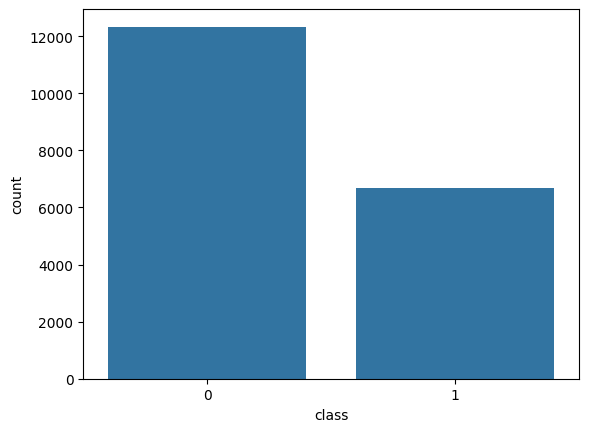

In [24]:
import seaborn as sns
sns.countplot(df, x="class")

In [25]:
tablegan_adapter.fit(x_train, y_train, epochs=10, batch_size=64)

---FIT TableGAN Model with high privacy setting
---Initialise TableGAN Model


d:\Anaconda3\envs\py39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Anaconda3\envs\py39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/10: [D loss: -0.2184] [G loss: 0.8668] [C loss: 0.3718]


In [26]:
# Generate synthetic data
synthetic_data = tablegan_adapter.generate(size=1000)

---Generate from TableGAN Model


In [27]:
synthetic_df = pd.DataFrame(synthetic_data)
x_sync_train = synthetic_df.drop(synthetic_df.columns[-1],axis=1).values
y_sync_train = synthetic_df.iloc[ :, -1:].values

In [28]:
# TSTR (train synthetic test real)
tstr_score_lr  = LogisticRegression().fit(x_sync_train, y_sync_train).score(x_test, y_test)
tstr_score_rf  = RandomForestClassifier().fit(x_sync_train, y_sync_train).score(x_test, y_test)
tstr_score_mlp = MLPClassifier().fit(x_sync_train, y_sync_train).score(x_test, y_test)
y_sync_train = LabelEncoder().fit_transform(y_sync_train)
xgbt_classifier = XGBClassifier(eval_metric='logloss')
tstr_score_xgbt = xgbt_classifier.fit(x_sync_train, y_sync_train).score(x_test, y_test)

# TRTR (train real test real)
trtr_score_lr  = LogisticRegression().fit(x_train, y_train).score(x_test, y_test)
trtr_score_rf  = RandomForestClassifier().fit(x_train, y_train).score(x_test, y_test)
trtr_score_mlp = MLPClassifier().fit(x_train, y_train).score(x_test, y_test)
xgbt_classifier = XGBClassifier(eval_metric='logloss', use_label_encoder=True)
trtr_score_xgbt = xgbt_classifier.fit(x_train, y_train).score(x_test, y_test)
df_evaluate = pd.DataFrame([
    ['TSTR', tstr_score_lr, tstr_score_rf, tstr_score_mlp, tstr_score_xgbt],
    ['TRTR', trtr_score_lr,trtr_score_rf,trtr_score_mlp, trtr_score_xgbt]
], columns=['Evaluated Item', 'LR', 'RF', 'MLP', 'XGBT'])
print(df_evaluate)

d:\Anaconda3\envs\py39\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda3\envs\py39\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Anaconda3\envs\py39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\envs\py39\lib\site-packages\s

  Evaluated Item        LR        RF       MLP      XGBT
0           TSTR  0.747108  0.742114  0.656677  0.775762
1           TRTR  0.786278  0.883018  0.839117  0.877234
